# Cotrain2

In [18]:
from functools import lru_cache
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from tqdm.notebook import tqdm

from mlflow_helper import retrieve, paired_ttest, unstack_reps
retrieve = lru_cache(retrieve)
from cotrain_helper import MetaLearner, LevelOneData, meta_learn, get_metrics, retrieve_metrics, meta_learn_show_results, plot_level_one_naive
from paracoord_helper import parallel_coordinates_and_hist

#%load_ext line_profiler
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## stacking: dataset

In [2]:
runs = retrieve('stacking', 'dataset', p=None)

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
140 2021-09-11 02:52:59.906000+00:00             dataset
141 2021-09-11 02:52:57.801000+00:00             dataset
142 2021-09-11 02:52:55.700000+00:00             dataset
143 2021-09-11 02:52:53.589000+00:00             dataset
144 2021-09-11 02:52:51.385000+00:00             dataset
..                               ...                 ...
275 2021-09-11 02:48:17.235000+00:00             dataset
276 2021-09-11 02:48:14.813000+00:00             dataset
277 2021-09-11 02:48:12.402000+00:00             dataset
278 2021-09-11 02:48:09.992000+00:00             dataset
279 2021-09-11 02:48:09.956000+00:00             dataset

[140 rows x 2 columns]


In [3]:
runs['Group'] = runs['params.estimator0'] + ' on ' + runs['params.dataset0'].str.upper()
fig, fig_alpha, dfs = meta_learn_show_results(
    run_name=runs,
    group_col='Group',
    rep_col='params.seed0',
    return_dfs=['df_styled']
)

In [4]:
dfs['df_styled']

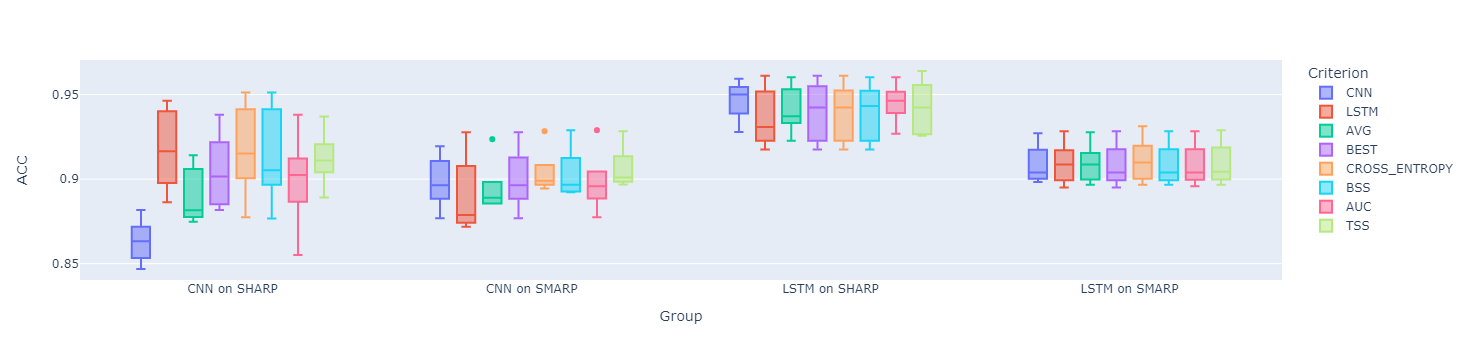

In [5]:
fig

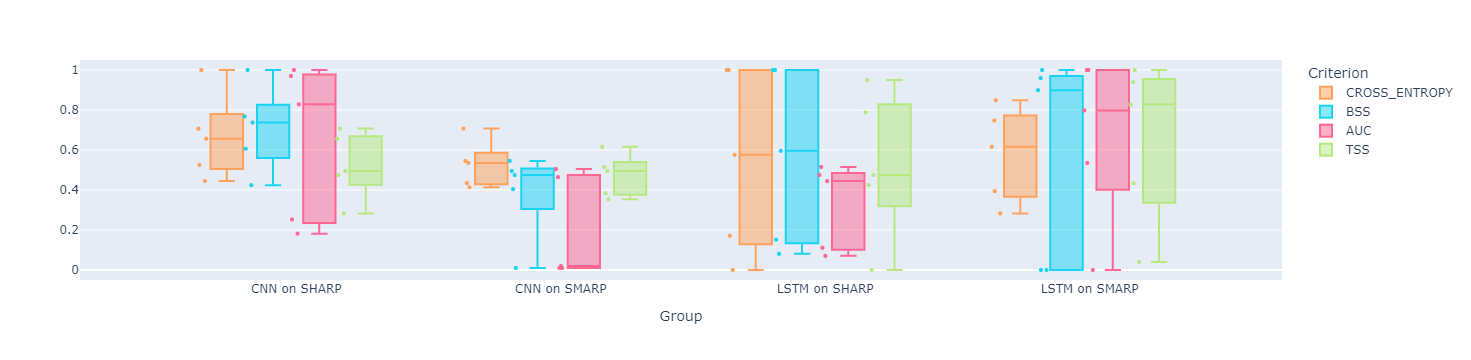

In [7]:
fig_alpha

## stacking: FN_bug(_2) (stacking CNN and LSTM)

In [8]:
runs = retrieve('stacking', 'FN_bug', p=None)
runs_2 = retrieve('stacking', 'FN_bug_2', p=None)
runs_comb = pd.concat((runs, runs_2))

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
420 2021-09-10 21:24:58.276000+00:00              FN_bug
421 2021-09-10 21:24:56.212000+00:00              FN_bug
422 2021-09-10 21:24:54.235000+00:00              FN_bug
423 2021-09-10 21:24:52.261000+00:00              FN_bug
424 2021-09-10 21:24:50.280000+00:00              FN_bug
..                               ...                 ...
555 2021-09-10 21:09:25.474000+00:00              FN_bug
556 2021-09-10 21:09:23.112000+00:00              FN_bug
557 2021-09-10 21:09:20.860000+00:00              FN_bug
558 2021-09-10 21:09:18.606000+00:00              FN_bug
559 2021-09-10 21:09:18.056000+00:00              FN_bug

[140 rows x 2 columns]
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
280 2021-09-10 21:41:21.651000+00:00            FN_bug_2
281 2021-09-10 21:41:19.177000+00:00            FN_bug_2
282 2021-09-10 21:41:16.696000+00:00 

In [9]:
fig, fig_alpha, dfs = meta_learn_show_results(
    run_name=runs_comb,
    group_col='params.dataset0',
    rep_col='params.seed0',
    criterion_eval='tss',
    return_dfs=['df_styled', 'df']
)

In [10]:
dfs['df_styled']

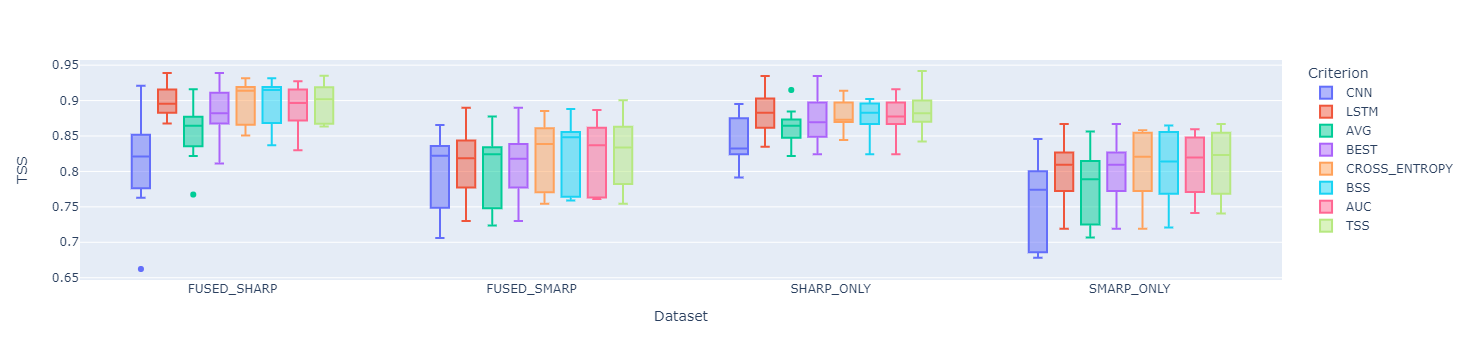

In [11]:
#fig.write_image('stacking.png', scale=2)
fig

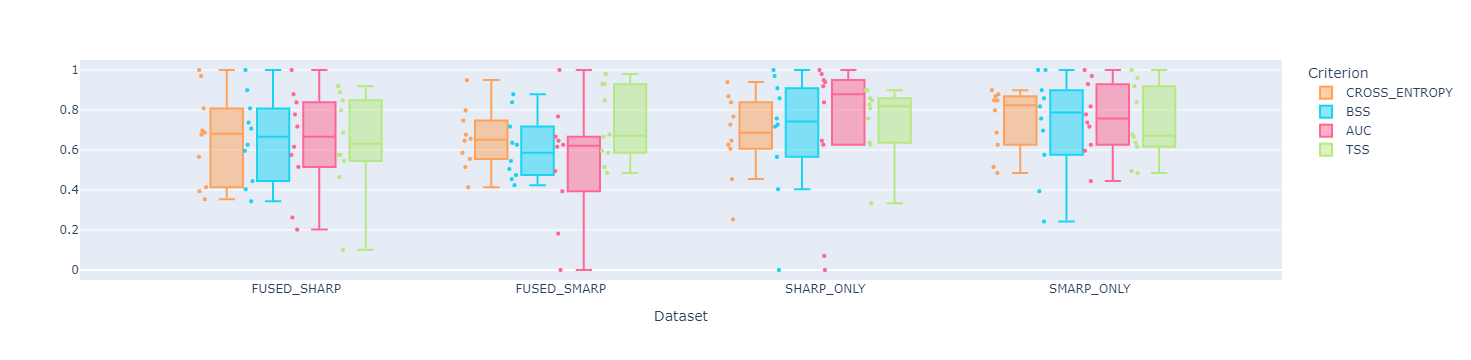

In [12]:
#fig_alpha.write_image('stacking_weights.png', scale=2)
fig_alpha

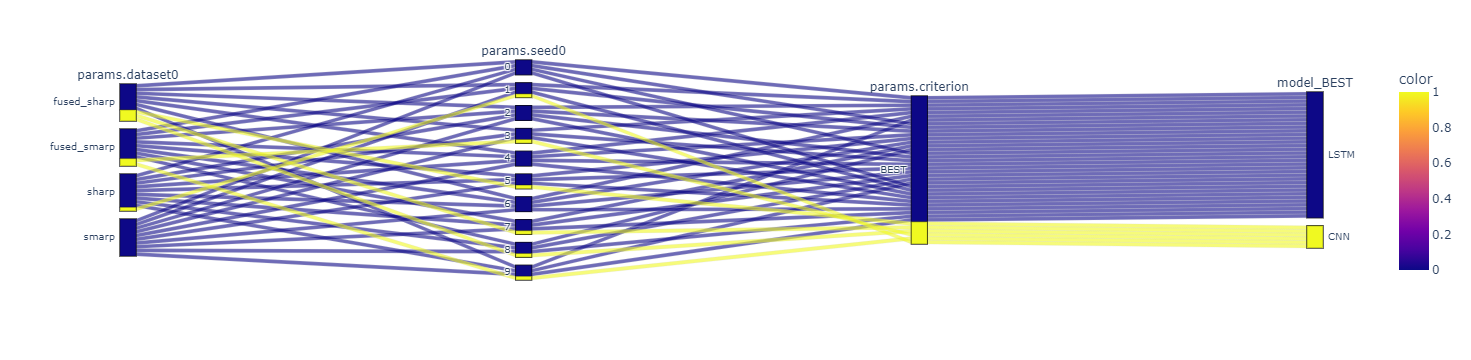

In [13]:
# df comes from within meta_learn_show_results
df_stacking = dfs['df'].dropna(subset=['model_BEST'])  # only keep stacking ensembles
px.parallel_categories(
    df_stacking,
    dimensions=['params.dataset0', 'params.seed0', 'params.criterion', 'model_BEST'],
    color=df_stacking['model_BEST'].map({'LSTM': 0, 'CNN': 1}) # the column has to be continuous
    #color='metrics.tss',
)
# parallel_coordinates_and_hist(
#     df_stacking
#     dimensions=[c for c in df.columns if c != 'run_id'],
#     color='metrics.tss',
#     color_hist='model_BEST')

We can inspect optimization by requesting saved record via REST API.

In [14]:
# Based on the df_styled, this stacking ensemble is better than the BEST
dataset = 'smarp'
criterion = 'tss'
seed = '3'

#df = runs_comb.loc[
#    (runs_comb['params.dataset0'] == dataset)
#    & (runs_comb['params.criterion'] == criterion)
#    ,
#    ['run_id', 'params.seed0', 'metrics.all_tss', 'metrics.all_oracle_tss', 'metrics.alpha', 'metrics.tss_over_best']
#].sort_values('params.seed0').reset_index(drop=True)

# Set_index is a good alternative
df = (runs_comb
      .set_index(['params.dataset0', 'params.criterion'])
      .loc[
          (dataset, criterion),
          ['run_id', 'params.seed0', 'metrics.all_tss', 'metrics.all_oracle_tss', 'metrics.alpha', 'metrics.tss_over_best']
      ]
     )
df

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/pandas/core/indexing.py:925: PerformanceWarning:

indexing past lexsort depth may impact performance.



run_id  \
params.dataset0 params.criterion                                     
smarp           tss               4e5cf31cd2ec430691ac973b5d6a8f98   
                tss               9abfed9f006944dd82e9395b90a68171   
                tss               584ca12fe094488cb7aa2e958154071e   
                tss               d6912fe84e984f1994f0c4cc25fdf071   
                tss               b3a430c765da42599c701b193bfd67d1   
                tss               51a8de2f105245e98384a6208d56a150   
                tss               073ce53f17694391865b8d1b6da54322   
                tss               76dfe0bd8d9f44da84cec4528d15717c   
                tss               c5786e424f304abfb1e68afc2fc0c1d7   
                tss               6475c61757f54acc926613862ba12264   

                                 params.seed0  metrics.all_tss  \
params.dataset0 params.criterion                                 
smarp           tss                         4         0.835040   
                tss                         3         0.869792   
                tss                         2         0.773676   
                tss                         1         0.730318   
                tss                         0         0.817442   
                tss                         9         0.795048   
                tss                         8         0.790541   
                tss                         7         0.825095   
                tss                         6         0.838083   
                tss                         5         0.862117   

                                  metrics.all_oracle_tss  metrics.alpha  \
params.dataset0 params.criterion                                          
smarp           tss                             0.790064       0.838384   
                tss                             0.817287       0.616162   
                tss                             0.856635       0.959596   
                tss                             0.826750       0.484848   
                tss                             0.801570       1.000000   
                tss                             0.821256       0.494949   
                tss                             0.867069       0.636364   
                tss                             0.772277       0.666667   
                tss                             0.719163       0.676768   
                tss                             0.729901       0.919192   

                                  metrics.tss_over_best  
params.dataset0 params.criterion                         
smarp           tss                            0.022436  
                tss                            0.037199  
                tss                           -0.001185  
                tss                            0.007181  
                tss                            0.000000  
                tss                            0.016103  
                tss                            0.000000  
                tss                           -0.003713  
                tss                            0.024229  
                tss                            0.010840

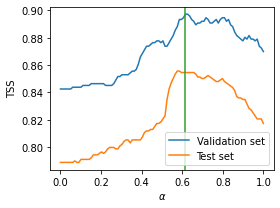

In [15]:
import requests
for i in range(len(df)):
    if df['params.seed0'].iloc[i] != seed:
        continue
    run_id = df['run_id'].iloc[i]
    all_tss = retrieve_metrics(run_id, 'all_tss')
    all_oracle_tss = retrieve_metrics(run_id, 'all_oracle_tss')
    alpha = retrieve_metrics(run_id, 'alpha')[0]

    alphas = np.linspace(0, 1, 100)
    plt.figure(figsize=(4, 3))
    plt.plot(alphas, all_tss, label='Validation set')
    plt.plot(alphas, all_oracle_tss, label='Test set')
    plt.axvline(x=alpha, c='C2')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('TSS')
    #plt.ylim([0.80, 0.97])
    plt.legend()
    #plt.savefig('alpha.png', bbox_inches='tight')
    plt.show()

## stacking: cv (single dataset, single test set)

In [16]:
dataset = 'smarp'
test_split = 0
criterion = 'auc'

members = [[f'cv/base/{dataset}/0/0/{test_split}/LSTM',
            '////1//',
            '////2//',
            '////3//',
            '////4//'
           ],
           [f'cv/base/{dataset}/0/0/{test_split}/CNN',
            '////1//',
            '////2//',
            '////3//',
            '////4//'
           ]]
levelone_cv = LevelOneData(members, get_train=False)
X_val, y_val, df_val = levelone_cv.get_split('val')

dict_values(['cv', 'base', 'smarp', '0', '0', '0', 'LSTM'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
200 2021-09-10 18:09:23.430000+00:00                base
dict_values(['cv', 'base', 'smarp', '0', '1', '0', 'LSTM'])
dict_values(['cv', 'base', 'smarp', '0', '2', '0', 'LSTM'])
dict_values(['cv', 'base', 'smarp', '0', '3', '0', 'LSTM'])
dict_values(['cv', 'base', 'smarp', '0', '4', '0', 'LSTM'])
dict_values(['cv', 'base', 'smarp', '0', '0', '0', 'CNN'])
dict_values(['cv', 'base', 'smarp', '0', '1', '0', 'CNN'])
dict_values(['cv', 'base', 'smarp', '0', '2', '0', 'CNN'])
dict_values(['cv', 'base', 'smarp', '0', '3', '0', 'CNN'])
dict_values(['cv', 'base', 'smarp', '0', '4', '0', 'CNN'])


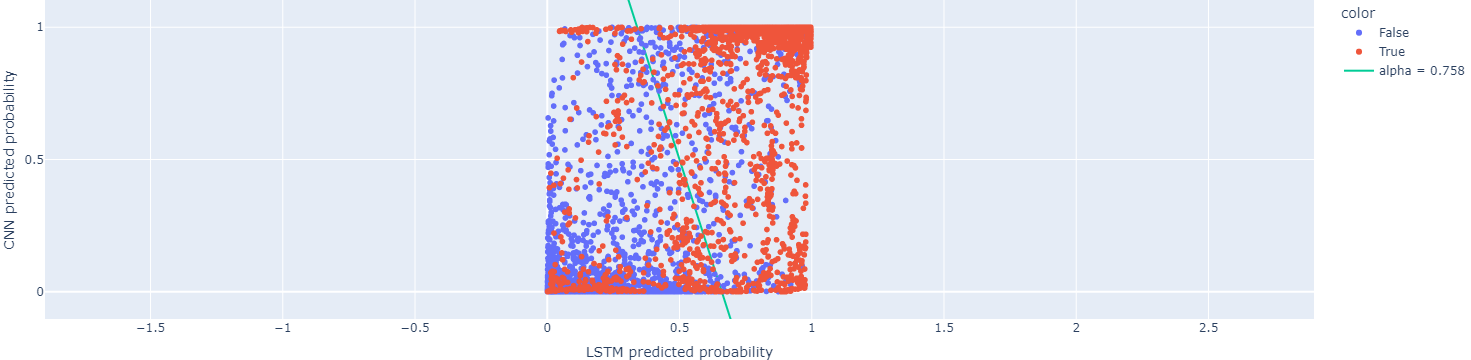

In [19]:
ml = MetaLearner(criterion=criterion, mode='max')
ml.fit(X_val, y_val)
plot_level_one_naive(X_val, y_val,
                     axis_titles=['LSTM predicted probability', 'CNN predicted probability'],
                     alpha=ml.alpha, meta=df_val)

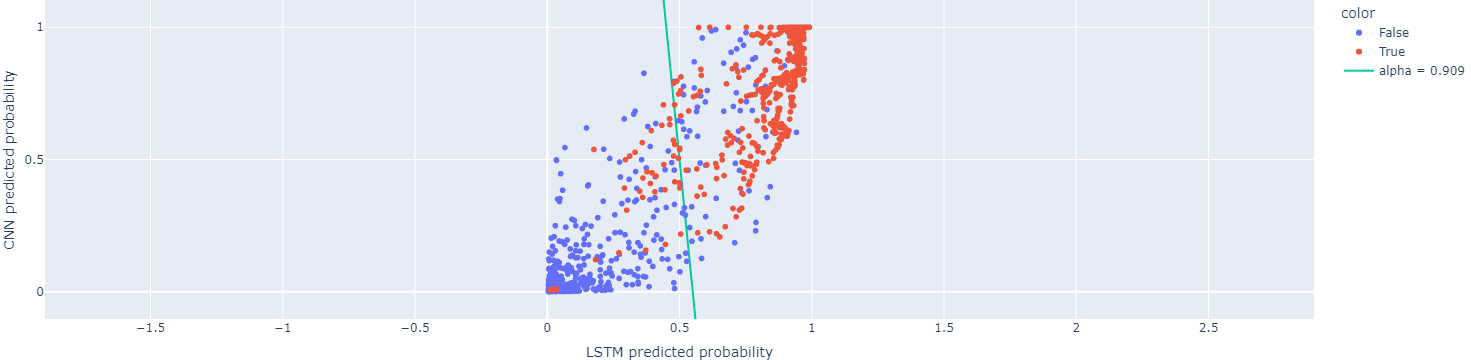

In [20]:
X_test, y_test, df_test = levelone_cv.get_split('test')

ml_test = MetaLearner(criterion=criterion, mode='max')
ml_test.fit(X_test, y_test)
plot_level_one_naive(X_test, y_test,
                     #X_err=X_test_std, # err is too large, especially points near 0.5
                     axis_titles=['LSTM predicted probability', 'CNN predicted probability'],
                     alpha=ml_test.alpha, meta=df_test)

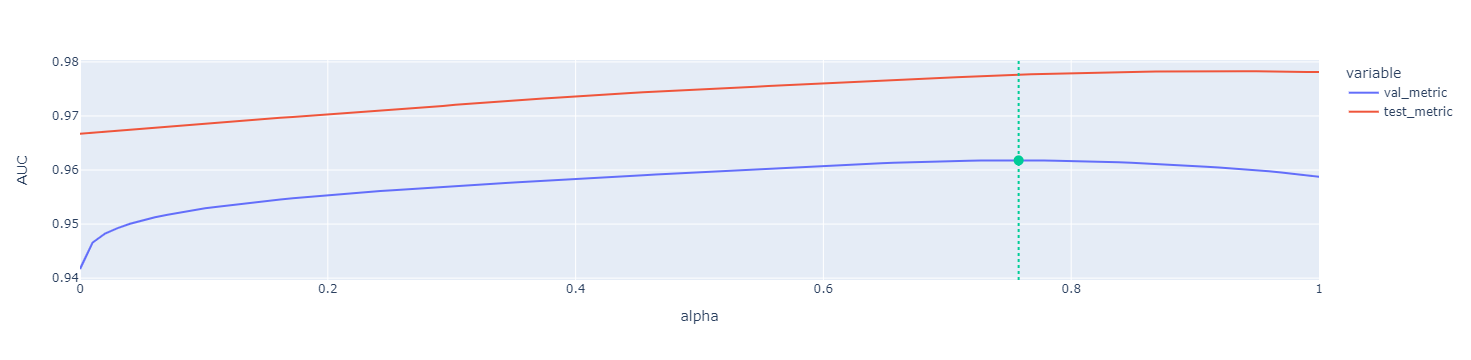

In [21]:
alphas = np.linspace(0, 1, 100)
df_alpha = pd.DataFrame({
    'alpha': alphas,
    'val_metric': [m[criterion] for m in ml.metrics],
    'test_metric': [m[criterion] for m in ml_test.metrics],
})
fig = px.line(df_alpha, x='alpha', y=['val_metric', 'test_metric'], labels={'value': criterion.upper()})
idx = np.argmax(df_alpha['val_metric'])
fig.add_trace(go.Scatter(x=[alphas[idx]], y=[ml.metrics[idx][criterion]], marker_size=10, showlegend=False))
fig.add_vline(x=alphas[idx], line_color=px.colors.qualitative.Plotly[2], line_dash='dot')

In [23]:
# # Validate
# runs = retrieve('stacking', 'cv', p=None)
# run_id = runs.loc[
#     (runs['params.dataset0'] == dataset) &
#     (runs['params.test_split0'] == str(test_split)) &
#     (runs['params.criterion'] == criterion)
#     ,
#     'run_id'
# ].item()

# alphas = np.linspace(0, 1, 100)
# df_alpha = pd.DataFrame({
#     'alpha': alphas,
#     'val_metric': [m for m in retrieve_metrics(run_id, f'all_{criterion}')],
#     'test_metric': [m for m in retrieve_metrics(run_id, f'all_oracle_{criterion}')],
# })
# fig = px.line(df_alpha, x='alpha', y=['val_metric', 'test_metric'], labels={'value': criterion.upper()})
# idx = np.argmax(df_alpha['val_metric'])
# fig.add_trace(go.Scatter(x=[alphas[idx]], y=[ml.metrics[idx][criterion]], marker_size=10, showlegend=False))
# fig.add_vline(x=alphas[idx], line_color=px.colors.qualitative.Plotly[2], line_dash='dot')

## stacking: cv (all datasets, all 5 test sets)
Use the script to call meta_learn with run_name 'cv'. The following cells retrieve and organize the mlflow results.

In [24]:
run_raw = retrieve('stacking', 'cv', p=None)

In [25]:
fig, fig_alpha, dfs = meta_learn_show_results(
    run_name=run_raw,
    group_col='params.dataset0',
    rep_col='params.test_split0',
    criterion_eval='acc',
    criteria_opt=[
        'LSTM', 'CNN',
        'AVG', 'BEST',
        'hinge',
        'cross_entropy',
        'bss', 'auc', 'f1', 'acc'
        #'acc', 'f1', 'bss', 'auc',
    ],
    return_dfs=['df_styled']
)

In [26]:
dfs['df_styled']

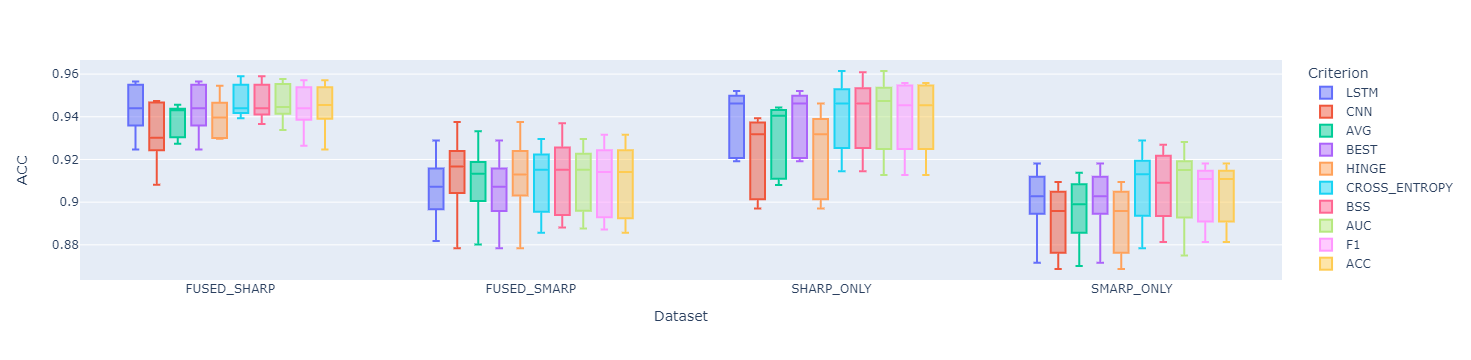

In [28]:
fig

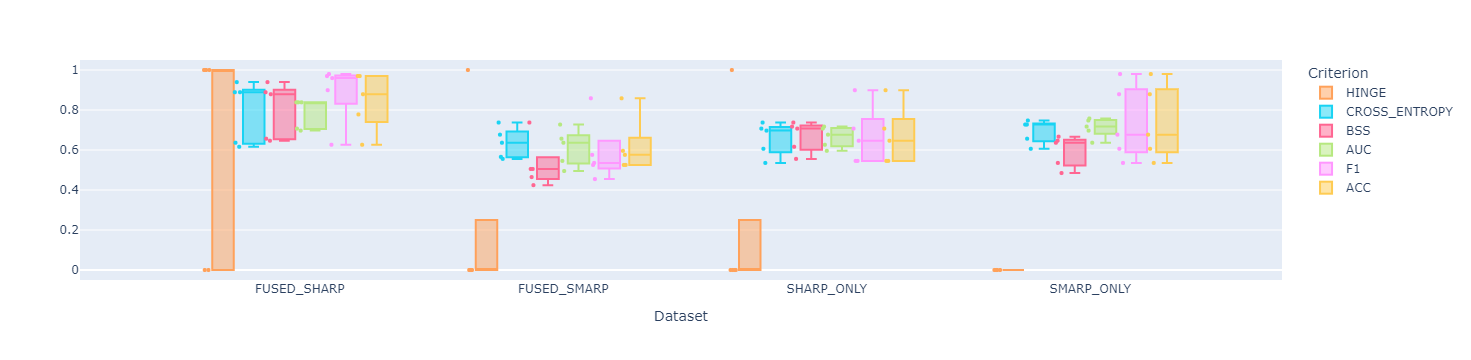

In [29]:
fig_alpha